In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

In [2]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
prdlabel = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
prdlabel = prdtype.loc[prdlabel['prdtypecode'], 'prdtypedesignation']
prdlabel = prdlabel.reset_index()

In [10]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated,tokens
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN,olivia carnet personnalisé pages grille points...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,journal arts n° 2001 art marche salon art asia...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,grand stylet ergonomique bleu gamepad nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,peluche donald europe disneyland 2000 marionne...
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,guerre tuques luc a idées grandeur veut organi...


## Identify duplicates with different product type code

In [ ]:
#identify duplicates with same designation and description but different product type code
data_duplicated = data.join(prdlabel.reset_index())
data_duplicated['description'] = data_duplicated['description'].fillna('')
data_duplicated = data_duplicated[data_duplicated.duplicated(['designation', 'description'], keep=False)]
data_duplicated = data_duplicated.groupby(['description', 'designation']).filter(lambda x: x['prdtypecode'].nunique() > 1)
idx_duplicates = data_duplicated.index

In [ ]:
#Remove those duplicates
data = data.drop(index=idx_duplicates)
prdlabel = prdlabel.drop(index=idx_duplicates)

## Vectorization functions

In [4]:
def fstxtvectorize(words, model):
    words = words.split()
    
    word_vectors = []
    for word in words:
        try:
            #getting the vector for each word
            word_vectors.append(model.wv[word])
        except KeyError:
            # If a word is not in the model, skip it
            continue

    # If we have at least one word vector, return the mean of the vectors
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        # If no words in the sentence are in the model, return a zero vector
        # The length of the zero vector should match the model's vector size
        return np.zeros(model.vector_size)

## Tokenize translated text

In [ ]:
#tokenize single columns
#from nltk.tokenize import word_tokenize
#colname = 'designation_translated' #'designation'
#data['tokens'] = data[colname].str.lower().apply(lambda x: word_tokenize(x, language='french'))

In [5]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Load stopwords from NLTK

In [6]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('french'))
new_stop_words = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
stop_words.update(new_stop_words)

In [7]:
def remove_stopwords(words, stopwords):
    #remove words in stopwords
    words_filtered = [word for word in words if word not in stopwords]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [8]:
#Removing stop words
data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stop_words))

#Removing duplicated tokens
#data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex? (optional)

In [9]:
import re

#remove numbers after n°
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"(?<=n°)\d+", ' ', x, re.IGNORECASE))

#remove words shorter than 3 characters except n°
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?!n°)\[a-záéíóúàèìòùâêîôûäëïöü]{1,2}\b", ' ', x, re.IGNORECASE))

#remove all numbers that are not 4 digits
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\d{1,3}\b|\b\d{5,}\b", ' ', x))

#remove all 4 digit numbers that are not starting with 18, 19 or 20
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?!18|19|20)\d{4}\b", ' ', x))

#remove any word that has no vowel and which is neither a digit or n°
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?!\d+\b)(?!n°)[^aeiouyáéíóúàèìòùâêîôûäëïöü\s\d]+\b", ' ', x))

#add space before and after anything that is in the following regex (doesn't work...)
data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r'(\d+|[-.,!¡;；:¯…„“\§«»—°•£❤☆(){}\[\]"@#$%^&*+=|<>~`‘’¬]/)', r" \1 ", x))

#removing extra spaces
data['tokens'] = data['tokens'].apply(lambda x: x.split())

#remove again everything that was in stopwords (in case there were missing spaces)
data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stop_words))
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Creating train and test sets

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV

target = prdlabel['prdtypedesignation']

#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

## Training FastText and vectorizing

In [12]:
from gensim.models.fasttext import load_facebook_model, load_facebook_vectors

model_path = os.path.join("C:", r"\Users\justj\Documents\DST\DS\Rakuten-project\fasttext_model", 'cc.fr.300.bin')
#model = load_facebook_vectors(model_path)

modelfst = load_facebook_model(model_path)

c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [13]:
tokens = X_train.str.split()
modelfst.build_vocab(tokens, update=True)
modelfst.train(tokens, total_examples=len(tokens), epochs=50)

(76931635, 208200500)

In [14]:
X_train = np.array([fstxtvectorize(row, modelfst) for row in X_train])
X_test = np.array([fstxtvectorize(row, modelfst) for row in X_test])

## Training doc2vec and vectorizing

In [118]:
from gensim.models.doc2vec import Doc2Vec
modeld2v = Doc2Vec(vector_size=100, min_count=0, epochs=40, workers=4)

In [121]:
from gensim.models.doc2vec import TaggedDocument

tokens = X_train.str.split()
#train_corpus = [TaggedDocument(words, [i]) for i, words in enumerate(tokens)]
train_corpus = [TaggedDocument(words, [i]) for i, words in zip(y_train, tokens)]
modeld2v.build_vocab(train_corpus)
modeld2v.train(train_corpus, total_examples=modeld2v.corpus_count, epochs=modeld2v.epochs)

In [122]:
X_train = np.array([modeld2v.infer_vector(row.split()) for row in X_train])
X_test = np.array([modeld2v.infer_vector(row.split()) for row in X_test])

## Normalize rows (optional)

In [131]:
from sklearn.preprocessing import normalize
X_train = normalize(X_train, norm='l2', axis=1)
X_test = normalize(X_test, norm='l2', axis=1)

## Function to plot results

In [17]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Linear SVM Classifier

In [34]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

svc = LinearSVC(penalty='l2', C=1, random_state=123, dual='auto', max_iter=10^6, class_weight='balanced')
#f1_weighted = make_scorer(f1_score, average='weighted',labels=y_train.unique()) doesn't work for some reason

params = {'C': np.linspace(0.5, 1.5, 11),
          'penalty': ['l1', 'l2'],
          'class_weight': [None]}

gridcv = GridSearchCV(svc, param_grid=params, cv=5, n_jobs=-1, scoring='f1_weighted')
gridcv.fit(X_train, y_train);

y_pred_svc = gridcv.predict(X_test)

print(gridcv.best_params_)

plot_classification_results(y_test, y_pred_svc);

KeyboardInterrupt: 

c:\Users\justj\.conda\envs\Rakuten\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                                precision    recall  f1-score   support

            Accessoires gaming       0.70      0.77      0.73       336
                    Animalerie       0.82      0.73      0.77       165
                Cartes de jeux       0.85      0.88      0.87       791
                   Confiseries       0.84      0.91      0.88       161
               Consoles de jeu       0.93      0.78      0.85       166
     Figurines et jeux de rôle       0.72      0.38      0.50       153
Figurines et objet pop culture       0.68      0.73      0.70       534
         Fournitures de bureau       0.87      0.89      0.88       998
       Jeux de société enfants       0.61      0.40      0.48       414
               Jeux techniques       0.78      0.91      0.84      1009
     Jeux vidéo CDs équipement       0.69      0.52      0.59       502
           Jeux vidéo occasion       0.72      0.71      0.72       284
            Jeux vidéo pour PC       0.89      0.98      0.93  

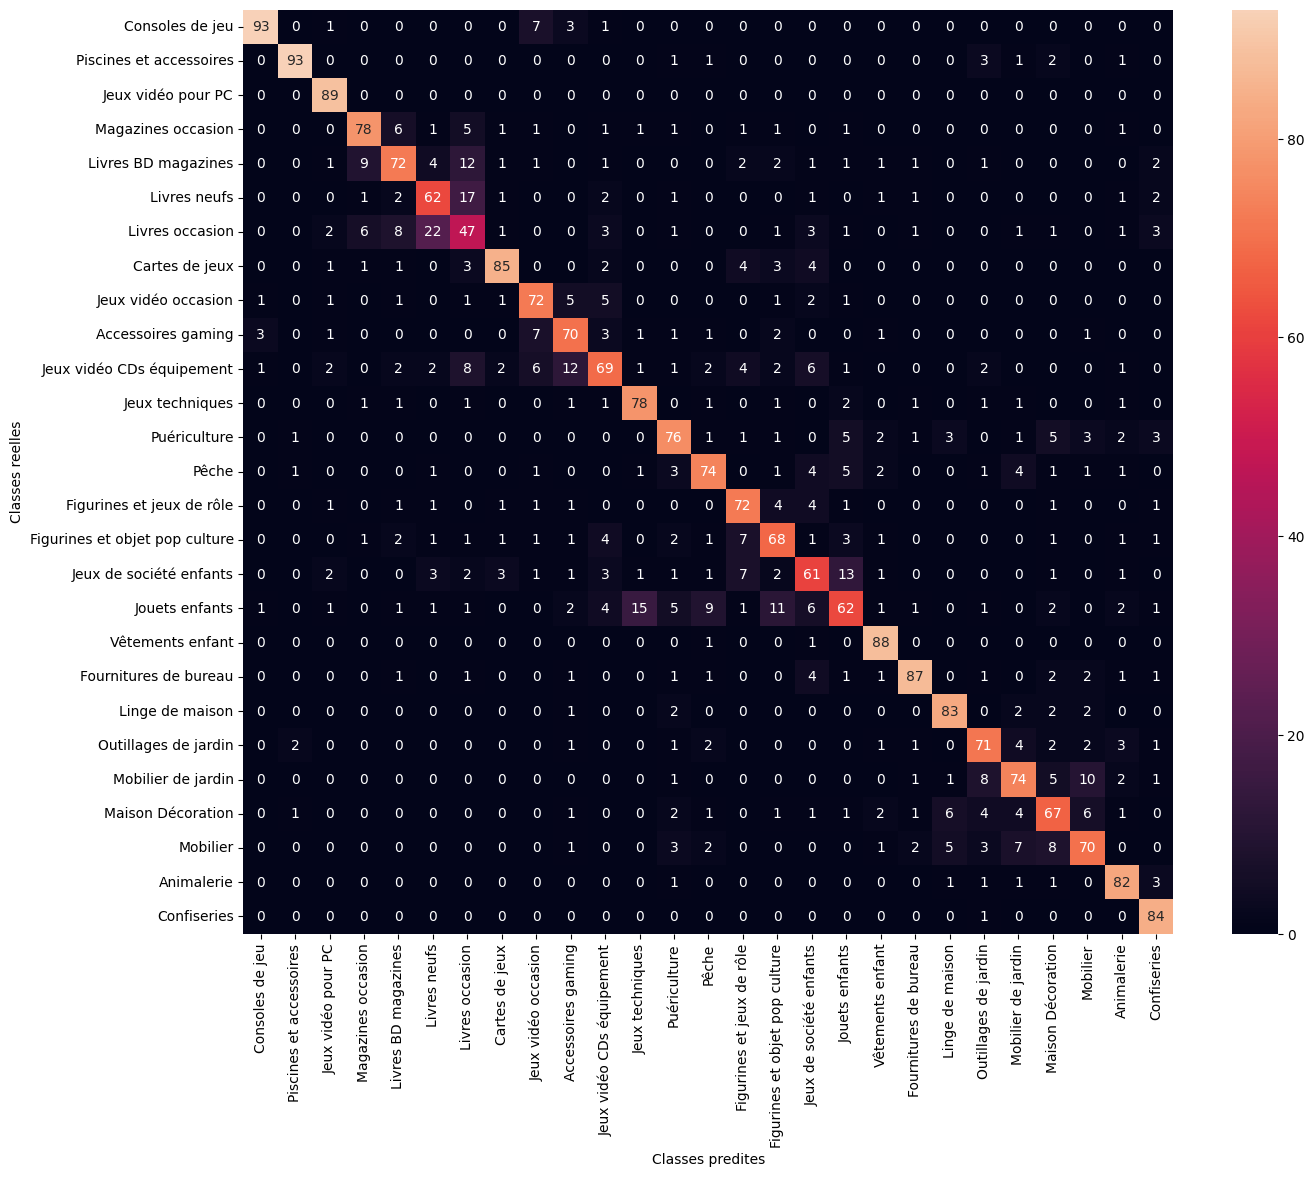

In [132]:
svc = LinearSVC(penalty='l2', C=1, random_state=123, dual='auto', max_iter=10^6)
svc.fit(X_train, y_train);

y_pred_svc = svc.predict(X_test)

plot_classification_results(y_test, y_pred_svc);

## xgBoost

In [15]:
code, mapping = pd.factorize(target)
mapping =pd.DataFrame({'category': mapping, 'code': range(len(mapping))}, index=mapping)
y_train_xgb = mapping.loc[y_train, 'code']
y_test_xgb = mapping.loc[y_test, 'code']

              precision    recall  f1-score   support

           0       0.45      0.53      0.49       623
           1       0.80      0.86      0.83       952
           2       0.79      0.77      0.78       336
           3       0.59      0.62      0.60       974
           4       0.78      0.67      0.72       552
           5       0.91      0.90      0.90       998
           6       0.77      0.64      0.70       518
           7       0.77      0.83      0.80      1015
           8       0.61      0.50      0.55       414
           9       0.90      0.91      0.91       861
          10       0.72      0.73      0.73       955
          11       0.73      0.73      0.73       534
          12       0.96      0.98      0.97      2042
          13       0.76      0.42      0.55       153
          14       0.81      0.90      0.85      1009
          15       0.75      0.73      0.74       284
          16       0.87      0.88      0.87       791
          17       0.75    

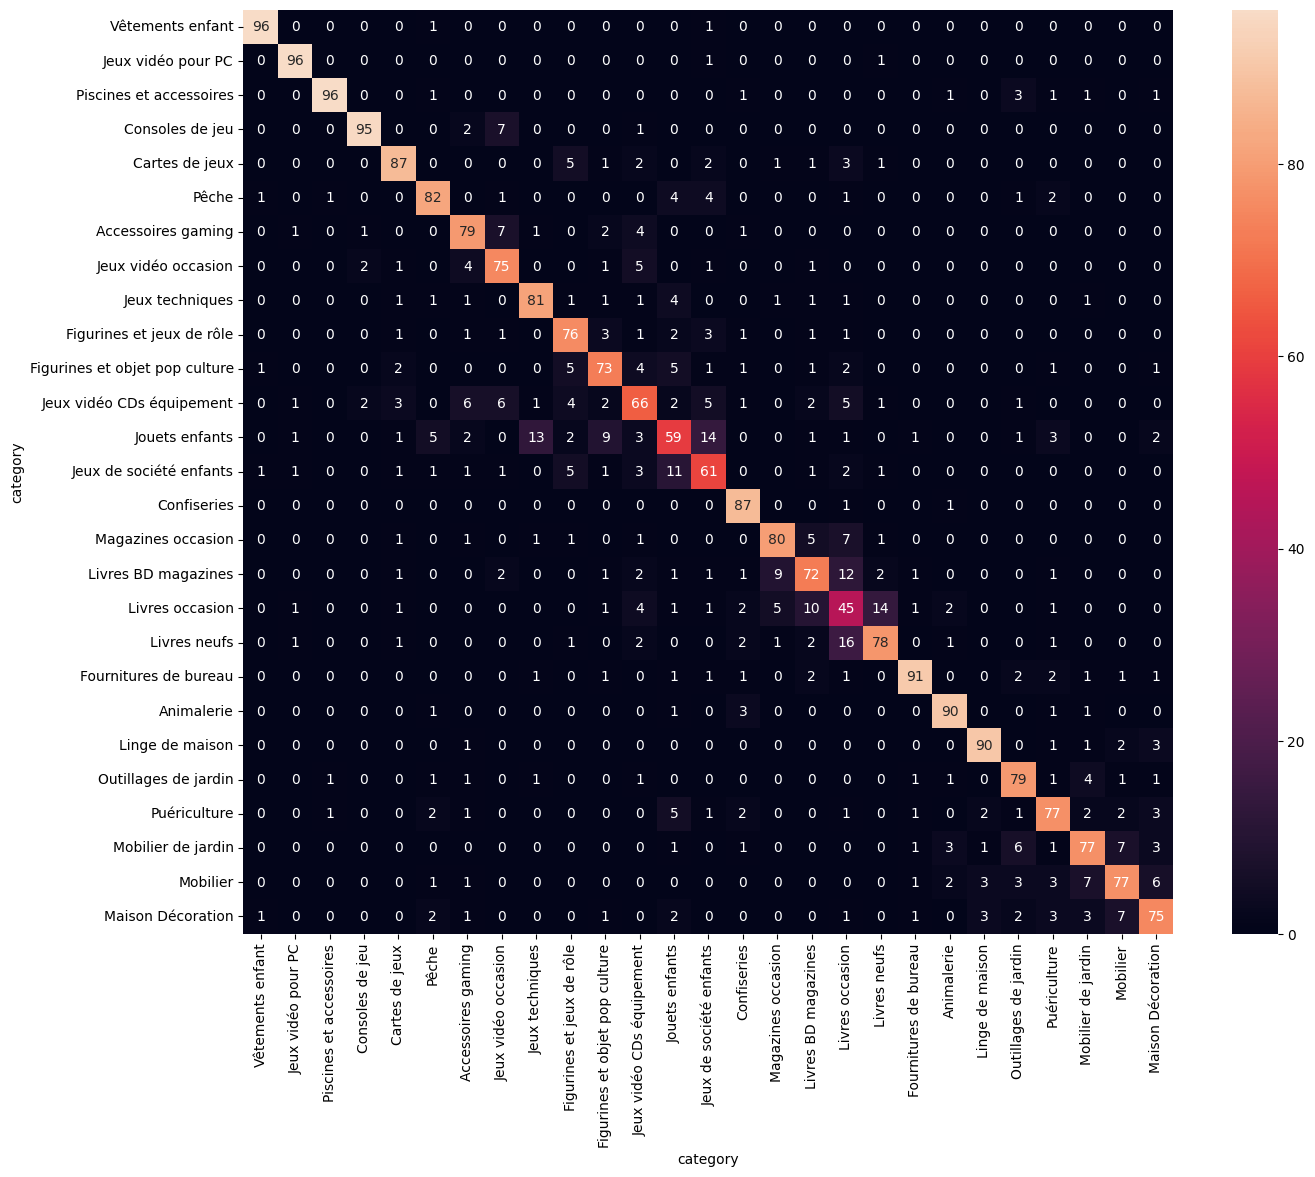

In [19]:
import xgboost as xgb

clf = xgb.XGBClassifier(objective='multi:softprob',max_depth=6, reg_alpha=0, n_estimators=200)
clf.fit(X_train, y_train_xgb)
y_pred_xgb = clf.predict(X_test)

plot_classification_results(y_test_xgb, y_pred_xgb, index=mapping['category']);